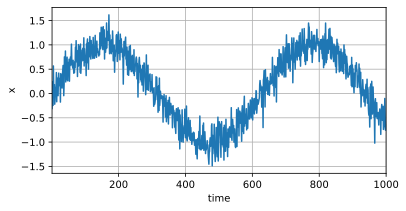

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
# tau is the embedding dimension
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [3]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.100035
epoch 2, loss: 0.076530
epoch 3, loss: 0.065218
epoch 4, loss: 0.057114
epoch 5, loss: 0.054352


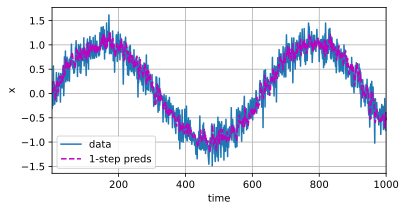

In [6]:
# prediction
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

In [8]:
# Usually, when we observe the sequence x to x_t, we call the prediction on the x_{t+k} as k-step-ahead-prediction
# Our observation on the sequence above is x_604 (600 + tau), and we use our prediction rather than original data to
# multi-step-ahead-prediction and see the result
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau: i].reshape((1, -1)))

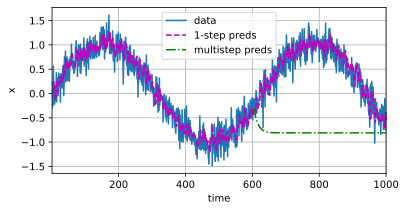

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],
         'time',
         'x', legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

It shows that the prediction of green line is not ideal, and the result decayed to a constant quickly after a few of steps.
It is because of the accumulation of the errors

In [10]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# column i (i < tau) is the observation from the x, and the step is from i to i + T - tau - max_steps + 1
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# column i (i < tau) is the prediction from the step (i - tau + 1), and the step is from i to i + T - tau - max_steps + 1
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau : i]).reshape(-1)

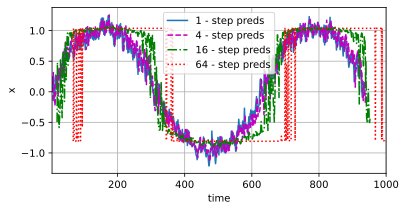

In [11]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i} - step preds' for i in steps], xlim=[5, 1000], figsize=(6, 3))